# Grad-CAM

In [72]:
import os

import pandas as pd
import xarray as xr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import matplotlib.cm as cm
from PIL import Image

from libs import generator
from libs import gradcam

In [73]:
#### Read streamflow ####
streamflow_path = "./data/discharge_timeseries.csv"
pd_streamflow = pd.read_csv(streamflow_path, sep=",", skiprows=2, header=0, decimal=".")
pd_streamflow["date"] = pd.to_datetime(pd_streamflow["date"])
pd_streamflow = pd_streamflow.rename(columns={"date": "time"})
pd_streamflow = pd_streamflow.melt(id_vars=["time"], var_name="basin", value_name="streamflow")
pd_streamflow = pd_streamflow.set_index(["time", "basin"])
ds_streamflow = pd_streamflow.to_xarray()

path = "./data/wv_regnie.nc"
xds = xr.open_dataset(path)
xds_merge = xds.merge(ds_streamflow)

In [74]:
# Split datasets
sample_basins = ["100050", "100044", "100057", "100064", "100051", "100072", "100063"]
out_of_sample_basins = ["100061", "100068", "100085", "159783", "100086"]

feature_vars = ["precipitation"]
target_var = "streamflow"
train_start_date = "1990-01-01"
train_end_date = "2010-12-31"
test_start_date = "2016-01-01"
test_end_date = "2020-12-31"
timesteps = 10
batch_size = 1
offset = 1

train_xds = xds_merge.sel(basin=sample_basins, time=slice(train_start_date, train_end_date))
test_xds = xds_merge.sel(basin=sample_basins, time=slice(test_start_date, test_end_date))

# Apply min/max scaling by using min and max from training dataset
xds_min = train_xds.min()
xds_max = train_xds.max()

test_xds = (test_xds - xds_min) / (xds_max - xds_min)

test_gen = generator.CustomTimeseriesGenerator(xds=test_xds, batch_size=batch_size, timesteps=timesteps,
                                               offset=offset, feature_vars=feature_vars, target_var=target_var,
                                               drop_na=False, joined_output=True)

In [84]:
# Load model
# cnn_model = tf.keras.models.load_model("./models/20220325133614_wv_bulk.h5")
# cnn_model = tf.keras.models.load_model("./models/20220331110412_wv_bulk.h5")
# cnn_model = tf.keras.models.load_model("./models/20220331150007_wv_bulk.h5")
# cnn_model = tf.keras.models.load_model("./models/20220401090231_wv_bulk.h5")
# cnn_model = tf.keras.models.load_model("./models/20220401101900_wv_bulk.h5")
# cnn_model = tf.keras.models.load_model("./models/20220401173449_wv_bulk.h5")
cnn_model = tf.keras.models.load_model("./models/20220408115245_wv_bulk.h5")

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 40, 41, 16)    32        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 38, 39, 16)    2320      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 36, 37, 16)    2320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 18, 18, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 14, 14, 32)    9248      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 32)            0

In [136]:
pred_index = 0  # basin
cnn_layer_name = "time_distributed_5"
lstm_layer_name = "lstm"
timestep = 0
basins = ["100050", "100044", "100057", "100064", "100051", "100072", "100063"]

inputs, targets = test_gen[40]

In [137]:
def create_grad_cam_heatmap(model, inputs, pred_index, last_conv_layer, timestep):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        feature_maps, cnn_preds = grad_model(inputs)
        # if cnn_pred_index is None:
        #     cnn_pred_index = tf.argmax(cnn_preds[cnn_pred_index])
        class_channel = cnn_preds[:, pred_index]

    grads = tape.gradient(class_channel, feature_maps)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 2, 3))

    feature_maps = feature_maps[0]

    heatmap_res = tf.zeros([0, feature_maps.shape[1], feature_maps.shape[2]])

    for i in range(0, feature_maps.shape[0]):
        heatmap = feature_maps[i, ...] @ pooled_grads[i, ..., tf.newaxis]
        heatmap = tf.reshape(heatmap, (1, heatmap.shape[0], heatmap.shape[1]))
        
        # if tf.math.reduce_max(heatmap) == 0:
        #     heatmap = tf.maximum(heatmap, 0)
        # else:
        #     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        heatmap_res = tf.concat([heatmap_res, heatmap], axis=0)
        
    heatmap_res = tf.maximum(heatmap_res, 0) / tf.math.reduce_max(heatmap_res)

    np_heatmap = heatmap_res.numpy()

    image = inputs[0, timestep, ..., 0]
    image_heatmap = np_heatmap[timestep, ...]

    image_heatmap = Image.fromarray(image_heatmap)
    image_heatmap = image_heatmap.resize((image.shape[1], image.shape[0]))
    image_heatmap = tf.keras.preprocessing.image.img_to_array(image_heatmap)

    return image_heatmap

In [148]:
def create_grad_lstm_cam_heatmap(model, inputs, pred_index, last_conv_layer, last_lstm_layer, timestep, mixed_weighting, scale_across_time):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        feature_maps, cnn_preds = grad_model(inputs)
        # if cnn_pred_index is None:
        #     cnn_pred_index = tf.argmax(cnn_preds[cnn_pred_index])
        class_channel = cnn_preds[:, pred_index]

    grads = tape.gradient(class_channel, feature_maps)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 2, 3))

    feature_maps = feature_maps[0]

    lstm_grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_lstm_layer).output, model.output]
    )

    with tf.GradientTape() as lstm_tape:
        lstm_feature_maps, lstm_preds = lstm_grad_model(inputs)
        # if cnn_pred_index is None:
        #     cnn_pred_index = tf.argmax(cnn_preds[cnn_pred_index])
        lstm_class_channel = lstm_preds[:, pred_index]

    lstm_grads = lstm_tape.gradient(lstm_class_channel, lstm_feature_maps)
    lstm_grads = lstm_grads[0]

    heatmap_res = tf.zeros([0, feature_maps.shape[1], feature_maps.shape[2]])

    for i in range(0, feature_maps.shape[0]):
        if mixed_weighting:
            heatmap = feature_maps[i, ...] @ (pooled_grads[i, ..., tf.newaxis] * lstm_grads[i, ..., tf.newaxis])
        else:
            heatmap = feature_maps[i, ...] @ lstm_grads[i, ..., tf.newaxis]
        heatmap = tf.reshape(heatmap, (1, heatmap.shape[0], heatmap.shape[1]))
        
        if not scale_across_time:
            if tf.math.reduce_max(heatmap) == 0:
                heatmap = tf.maximum(heatmap, 0)
            else:
                heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        heatmap_res = tf.concat([heatmap_res, heatmap], axis=0)

    if scale_across_time:
        heatmap_res = tf.maximum(heatmap_res, 0) / tf.math.reduce_max(heatmap_res)

    np_heatmap = heatmap_res.numpy()

    # t = 25
    image = inputs[0, timestep, ..., 0]
    image_heatmap = np_heatmap[timestep, ...]

    image_heatmap = Image.fromarray(image_heatmap)
    image_heatmap = image_heatmap.resize((image.shape[1], image.shape[0]))
    image_heatmap = tf.keras.preprocessing.image.img_to_array(image_heatmap)

    return image_heatmap

In [149]:
heatmap_timeseries_list = []
for t in range(0, timesteps):
    heatmap_list = []
    for i in range(0, 7):
        image_heatmap = create_grad_cam_heatmap(cnn_model, inputs, pred_index=i, last_conv_layer=cnn_layer_name, timestep=t)
        heatmap_list.append(image_heatmap)
    heatmap_timeseries_list.append(heatmap_list)

In [150]:
plt.style.use('seaborn-ticks')

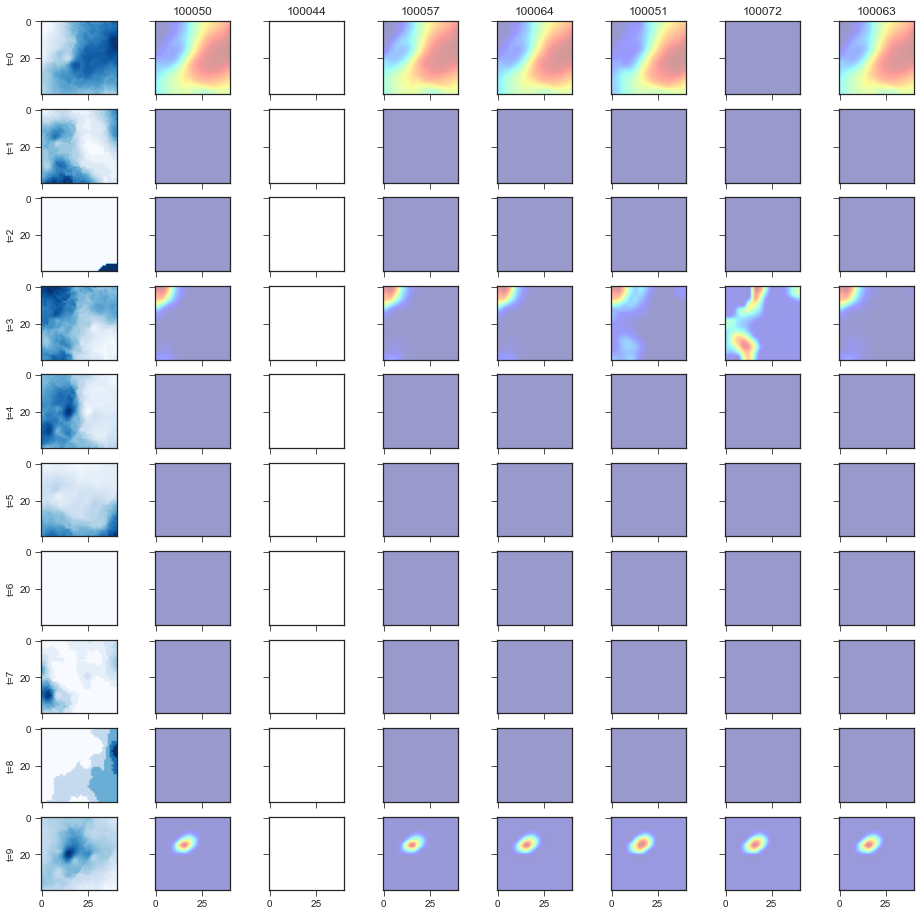

In [151]:
fig, axis = plt.subplots(timesteps, 8, figsize=(16, 16), sharex="all", sharey="all")

for t in range(0, timesteps):
    image = inputs[0, t, ..., 0]
    axis[t, 0].imshow(image, cmap="Blues")
    # axis[0].imshow(image, cmap="gray")
    for i in range(0, 7):
        ax = axis[t, i + 1]
        # ax = axis[i + 1]
        ax.imshow(heatmap_timeseries_list[t][i], cmap="jet", alpha=0.4)
        # plt.xlabel(basins[i])

for ax, col in zip(axis[0,1:8], basins):
    ax.set_title(col)

row_labels = [f"t={t}" for t in range (0,11)]
for ax, row in zip(axis[:,0], row_labels):
    ax.set_ylabel(row)

In [157]:
heatmap_lstm_timeseries_list = []
for t in range(0, timesteps):
    heatmap_lstm_list = []
    for i in range(0, 7):
        image_heatmap = create_grad_lstm_cam_heatmap(cnn_model, inputs, pred_index=i, last_conv_layer=cnn_layer_name, last_lstm_layer=lstm_layer_name,
                                                     timestep=t, mixed_weighting=False, scale_across_time=True)
        heatmap_lstm_list.append(image_heatmap)
    heatmap_lstm_timeseries_list.append(heatmap_lstm_list)

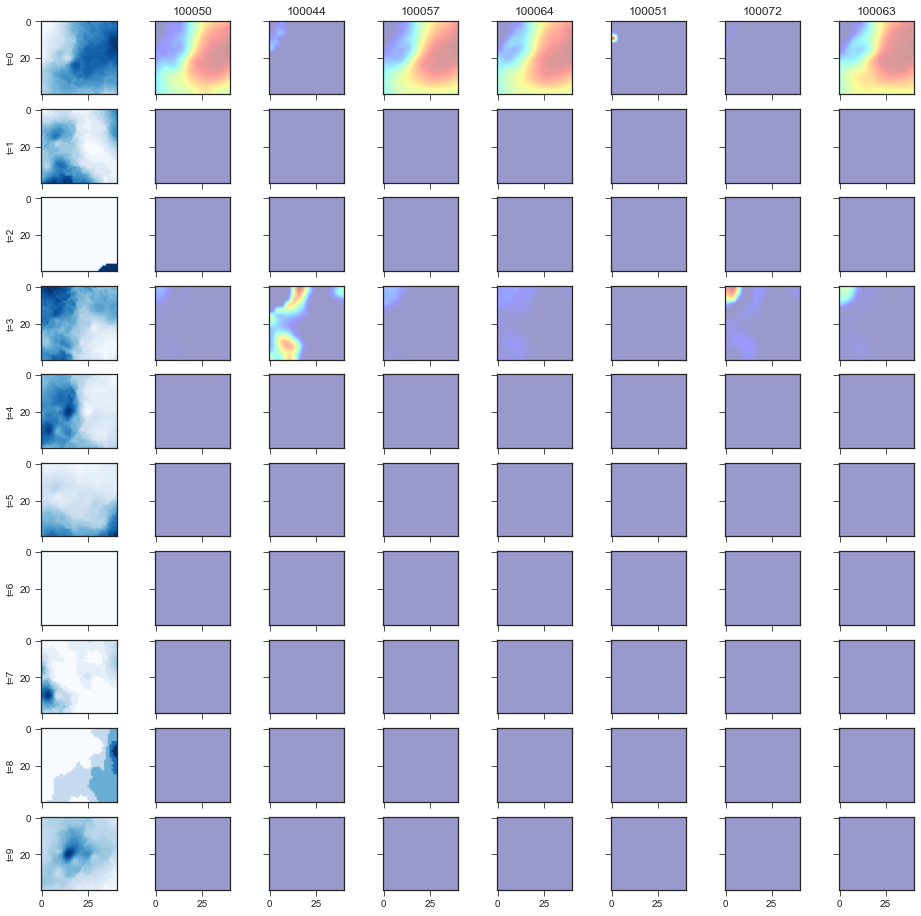

In [158]:
fig, axis = plt.subplots(timesteps, 8, figsize=(16, 16), sharex="all", sharey="all")

for t in range(0, timesteps):
    image = inputs[0, t, ..., 0]
    axis[t, 0].imshow(image, cmap="Blues")
    # axis[0].imshow(image, cmap="gray")
    for i in range(0, 7):
        ax = axis[t, i + 1]
        # ax = axis[i + 1]
        ax.imshow(heatmap_lstm_timeseries_list[t][i], cmap="jet", alpha=0.4, vmin=0, vmax=1)
        # plt.xlabel(basins[i])

for ax, col in zip(axis[0,1:8], basins):
    ax.set_title(col)

row_labels = [f"t={t}" for t in range (0,11)]
for ax, row in zip(axis[:,0], row_labels):
    ax.set_ylabel(row)

In [144]:
heatmap_lstm_timeseries_list = []
for t in range(0, timesteps):
    heatmap_lstm_list = []
    for i in range(0, 7):
        image_heatmap = create_grad_lstm_cam_heatmap(cnn_model, inputs, pred_index=i, last_conv_layer=cnn_layer_name, last_lstm_layer=lstm_layer_name, timestep=t, mixed_weighting=False)
        heatmap_lstm_list.append(image_heatmap)
    heatmap_lstm_timeseries_list.append(heatmap_lstm_list)

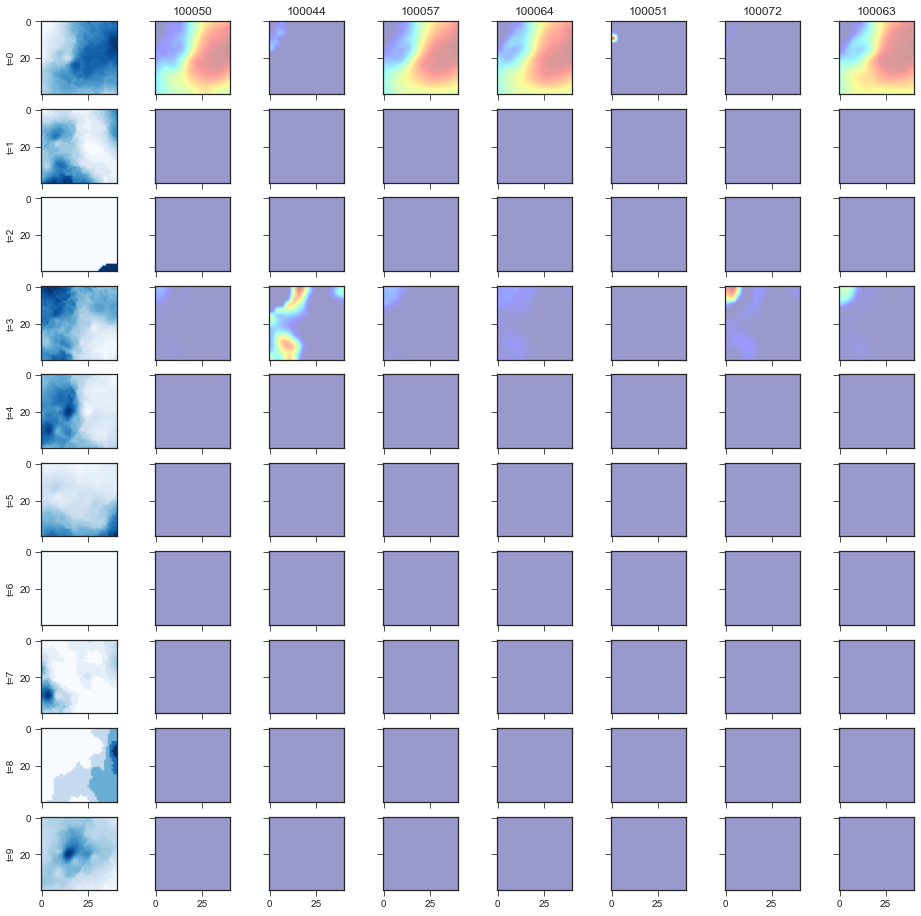

In [145]:
fig, axis = plt.subplots(timesteps, 8, figsize=(16, 16), sharex="all", sharey="all")

for t in range(0, timesteps):
    image = inputs[0, t, ..., 0]
    axis[t, 0].imshow(image, cmap="Blues")
    # axis[0].imshow(image, cmap="gray")
    for i in range(0, 7):
        ax = axis[t, i + 1]
        # ax = axis[i + 1]
        ax.imshow(heatmap_lstm_timeseries_list[t][i], cmap="jet", alpha=0.4, vmin=0, vmax=1)
        # plt.xlabel(basins[i])

for ax, col in zip(axis[0,1:8], basins):
    ax.set_title(col)

row_labels = [f"t={t}" for t in range (0,11)]
for ax, row in zip(axis[:,0], row_labels):
    ax.set_ylabel(row)